In [1]:
import keras
import numpy as np
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
print(train_data.shape,test_data.shape)

(404, 13) (102, 13)


In [2]:
#normalization
#由於test_data應保持完全未知，所以用train_data之平均與標準差進行標準化
mean=np.mean(train_data,axis=0)
std=np.std(train_data,axis=0)
#broadcast
train_data=(train_data-mean)/std
test_data=(test_data-mean)/std
print(train_data.shape,mean.shape,std.shape)

(404, 13) (13,) (13,)


In [3]:
from keras import models
from keras import layers

def build_model(input_data):
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(input_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
import math

#K-fold cross-validation
all_scores=[]
k=4
num_val_samples=math.floor(len(train_data)/k)
for i in range(k):
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
    #val前後以Y軸相連
    partial_train_data=np.concatenate(
        [train_data[:i*num_val_samples,:],train_data[(i+1)*num_val_samples:,:]],axis=0)
    partial_train_targets=np.concatenate(
        [train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    
    model = build_model(partial_train_data)
    history=model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=200, batch_size=16, verbose=0)
    mae_history = history.history['val_mae']
    all_scores.append(mae_history)
    



In [5]:
print(np.shape(all_scores))

(4, 200)


In [7]:
#計算每一個epoch的平均mae
mae_average_epoch=np.mean(all_scores,axis=0)
print(mae_average_epoch.shape)

(200,)


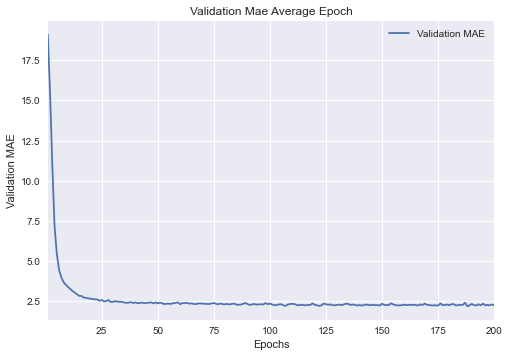

In [14]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

def plot_validation_loss(mae_average_epoch,title):
    epoch=np.arange(1,len(mae_average_epoch)+1)
    plt.plot(epoch, mae_average_epoch , '-', label='Validation MAE')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.xlim(1,len(epoch))
    plt.ylabel('Validation MAE')
    plt.legend()
    plt.show()
    
plot_validation_loss(mae_average_epoch,'Validation Mae Average Epoch')

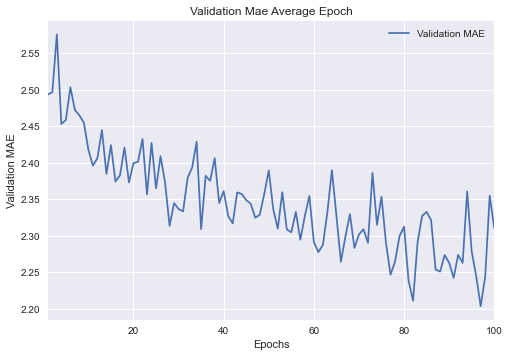

In [16]:
#可以看到曲線非常曲折
plot_validation_loss(mae_average_epoch[25:125],'Validation Mae Average Epoch')

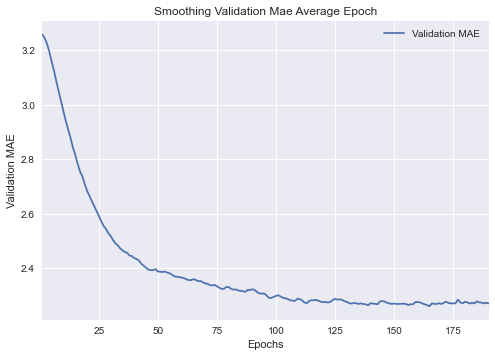

In [19]:
#把曲線變平穩，EXPONENTIAL SMOTHING
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(mae_average_epoch[10:])

plot_validation_loss(smooth_mae_history,'Smoothing Validation Mae Average Epoch')

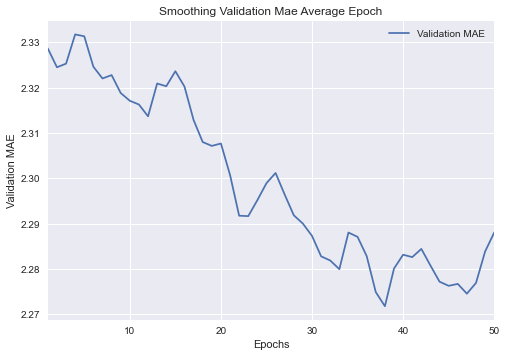

In [21]:
#epoch=112 後有overfitting
plot_validation_loss(smooth_mae_history[75:125],'Smoothing Validation Mae Average Epoch')

In [22]:
model = build_model(train_data)
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=112, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 15.2312 - mae: 2.4886


In [23]:
#誤差大概在2488美金
test_mae_score

2.4886255264282227

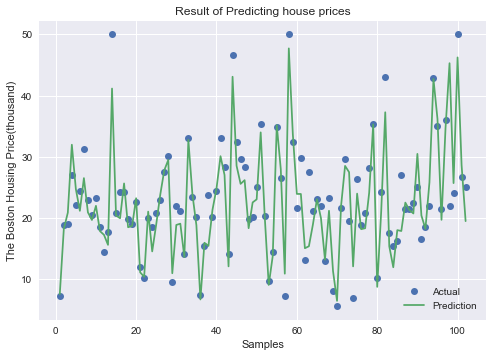

In [32]:
fit=model.predict(test_data)
plt.plot(np.arange(1,len(fit)+1),test_targets,'o', label='Actual')
plt.plot(np.arange(1,len(fit)+1),fit,'-',label='Prediction')
plt.title('Result of Predicting house prices')
plt.xlabel('Samples')
plt.ylabel('The Boston Housing Price(thousand)')
plt.legend()
plt.show()